In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression,LinearRegression,Ridge,Lasso
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


In [2]:
data = pd.read_csv('processed_data.csv')
data['release_date'] = pd.to_datetime(data['release_date'])
data['month'] = data.apply(lambda row:row['release_date'].month,axis=1)
data = pd.get_dummies(data,columns=['month'])
data['profit'] = data['revenue']- data['budget']
data['ROI'] = data['profit']/data['budget']
data['release_date'] = pd.to_datetime(data['release_date'])
data['revenue'] = np.log(data['revenue'])
data['profit'] = np.log(data['profit'])
data['budget'] = np.log(data['budget'])

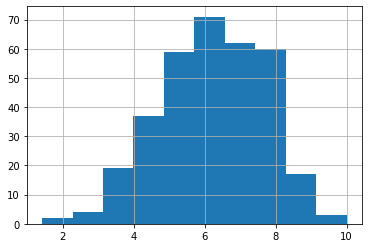

In [3]:
data['review_score'].hist()
plt.show()

In [4]:
def transform_score(score, bins):
    for index, bin_ in enumerate(bins):
        if score >= bin_[0] and score <= bin_[1]:
            return index


def bin_review_score(data, k=2):
    quantile = 1/k
    bins = [(0,data['review_score'].quantile(quantile))]
    for i in range(1,k-1):
        bins.append((data['review_score'].quantile(quantile), data['review_score'].quantile(quantile+1/k)))
        quantile += 1/k
    bins.append((data['review_score'].quantile(quantile),10))
    data['score'] = data['review_score'].apply(lambda score: transform_score(score, bins))
    data = data.drop('review_score',axis = 1)
    return data
new_data = bin_review_score(data.copy(deep =True),5)

In [5]:
new_data

,release_date,budget,is_top_production_company,know_actors,runtime,revenue,know_directors,popularity,title,Action,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,profit,ROI,score
0,2013-10-18,20000000,True,0,134.0,187000000,False,30.316249,12 years a slave,0,...,0,0,0,0,1,0,0,167000000,8.350000,4
1,2010-11-05,18000000,True,0,94.0,35692920,True,11.176797,127 hours,0,...,0,0,0,0,0,1,0,17692920,0.982940,4
2,2014-04-18,5000000,False,0,93.0,13809,False,9.067788,13 sins,0,...,0,0,0,0,0,0,0,-4986191,-0.997238,1
3,2013-08-02,61000000,True,1,109.0,131940411,False,13.336512,2 guns,1,...,0,0,1,0,0,0,0,70940411,1.162958,2
4,2014-06-05,50000000,True,0,112.0,188441614,False,10.901496,22 jump street,1,...,1,0,0,0,0,0,0,138441614,2.768832,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,2015-10-15,12000000,False,0,123.0,14394097,False,3.216606,woodlawn,0,...,0,0,0,0,1,0,0,2394097,0.199508,2
330,2010-09-24,20000000,False,1,105.0,32005248,False,12.820452,you again,0,...,0,0,0,1,0,0,0,12005248,0.600262,0
331,2011-12-16,12000000,True,0,94.0,22939027,True,6.142913,young adult,0,...,0,0,0,0,0,0,1,10939027,0.911586,3
332,2011-04-08,49900000,True,0,102.0,26121638,False,5.673750,your highness,0,...,0,0,0,0,0,0,0,-23778362,-0.476520,0


In [6]:
def logistic_regression_model(data):
    data_frames = {}
    labels = sorted(data['score'].unique())
    for label in labels[:-1]:
        curr_data = data[(data['score']==label) | (data['score'] == label + 1)]
        curr_data = curr_data.copy(deep = True)
        features_list = curr_data.drop(['score','release_date','popularity','title','profit','ROI','revenue'],axis =1).columns
        scaler = MinMaxScaler()
        curr_data[['budget','runtime']] = scaler.fit_transform(curr_data[['budget','runtime',]])
        model = LogisticRegression('none',max_iter = 1000)
        model.fit(curr_data[features_list],curr_data['score'])
        propensity_scores = model.predict_proba(curr_data[features_list])
        curr_data[f'propensity_class_{label}'] = propensity_scores[:,0]
        curr_data[f'propensity_class_{label+1}'] = propensity_scores[:,1]
        data_frames[(label,label+1)] = curr_data
    return data_frames
original_data_frames = logistic_regression_model(new_data.copy(deep = True))

In [7]:
def plot_classes_propensity(data):
    for label in data['score'].unique():
        label_movies_propensity = data[data['score'] == label][f'propensity_class_{label}']
        plt.hist(label_movies_propensity,bins=20,label=label,alpha=0.5)
    plt.legend()
    plt.xlabel('propensity score')
    plt.ylabel('number of units')
    plt.xlim(0,1)
    plt.show()

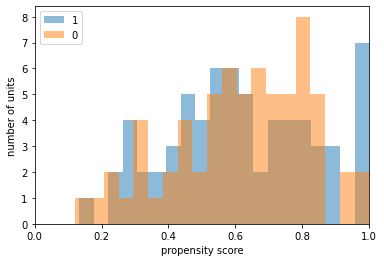

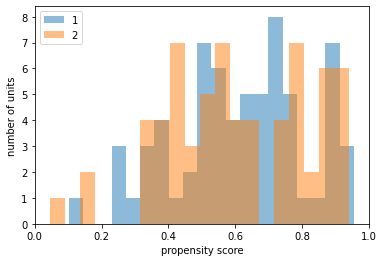

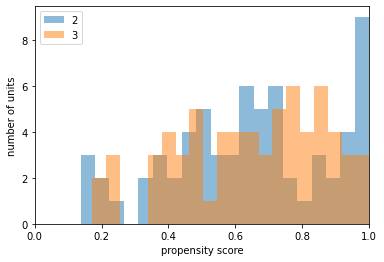

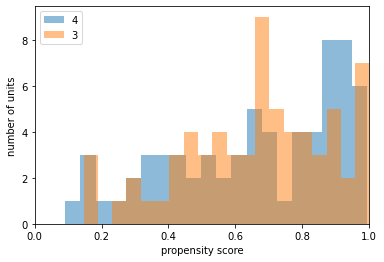

In [8]:
for key in original_data_frames.keys():
    plot_classes_propensity(original_data_frames[key])

In [9]:
def trim_common_support(data, label_name):
    """ Removes observations that fall outside the common support of the propensity score
        distribution from the data.

    Arguments:
    ----------
        data:        DataFrame with the propensity scores for each observation.
        label_name:  Column name that contains the labels (treatment/control) for each observation.

    """
    propensity_bounds_per_class = {}
    labels = sorted(data[label_name].unique())
    for label in labels:
        label_propensity = data[data[label_name]==label][f'propensity_class_{label}']
        propensity_bounds_per_class[label] = (min(label_propensity),max(label_propensity))
    for label in labels[:-1]:
        bound_one = propensity_bounds_per_class[label]
        bound_two = propensity_bounds_per_class[label+1]
        for bound in [bound_one,bound_two]:
            data = data[(data[f'propensity_class_{label}']>=bound[0]) & (data[f'propensity_class_{label}']<=bound[1])]
            data = data[(data[f'propensity_class_{label+1}']>=bound[0]) & (data[f'propensity_class_{label+1}']<=bound[1])]
    return data
trimmed_data_frames= {}
for key in original_data_frames.keys():
    trimmed_data_frames[key] = trim_common_support(original_data_frames[key],'score')

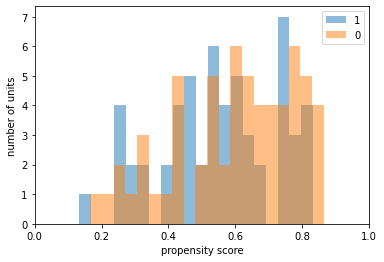

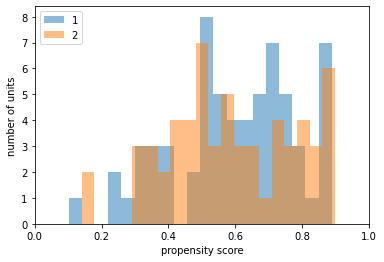

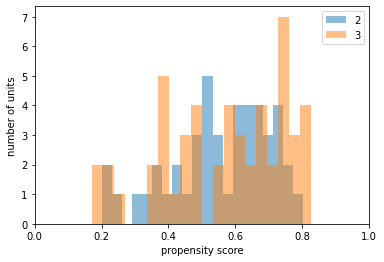

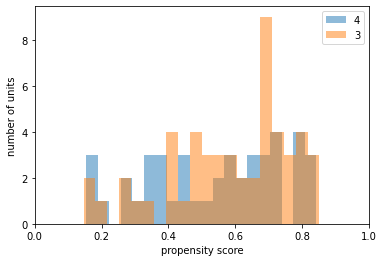

In [10]:
for key in trimmed_data_frames.keys():
    plot_classes_propensity(trimmed_data_frames[key])

# Models

In [12]:
def add_interactions(data,treatment):
    for column in data.columns:
        if column in [treatment]:
            continue
        data[column + '_interaction'] = data[column].copy(deep = True) * data[treatment].copy(deep = True)
    return data

def generate_S_learner(data,features,treatment,outcome):
    labels = data.pop(outcome)
    data = add_interactions(data[list(features)+[treatment]],treatment)
    model = Ridge(max_iter=100000)
    model.fit(data,labels)
    return model

def generate_T_learners(data,features,treatment,outcome):
    models = {}
    labels = list(data[treatment].unique())
    for label in labels:
        rel_data = data[data[treatment] == label]
        model = Ridge(max_iter=1000000)
        model.fit(rel_data[features],rel_data[outcome])
        print(model.score(rel_data[features],rel_data[outcome]))
        models[label] = model
    return models

def calc_all_ATE_T_learner(data,features,treatment,models):
    ATES ={}
    labels = list(data[treatment].unique())
    labels = sorted(labels,reverse=True)
    for index, label in enumerate(labels):
        for label2 in labels[index+1:]:
            model_1 = models[label]
            model_2 = models[label2]
            pred_1 = model_1.predict(data[features])
            pred_2 = model_2.predict(data[features])
            ATE = np.mean(pred_1-pred_2)
            ATES[(label,label2)] = ATE
    return ATES

def calc_all_ATE_S_learner(data,features,treatment,model):
    ATES ={}
    labels = list(data[treatment].unique())
    labels = sorted(labels,reverse=True)
    for index, label in enumerate(labels):
        for label2 in labels[index+1:]:
            data_t_label_1 = data.copy(deep =True)
            data_t_label_1[treatment] = label
            data_t_label_2 = data.copy(deep = True)
            data_t_label_2[treatment] = label2
            data_t_label_1 = add_interactions(data_t_label_1[features+[treatment]],treatment)
            data_t_label_2 = add_interactions(data_t_label_2[features+[treatment]],treatment)
            pred_1 = model.predict(data_t_label_1)
            pred_2 = model.predict(data_t_label_2)
            ATE = np.mean(pred_1-pred_2)
            ATES[(label,label2)] = ATE
    return ATES

def calculate_ATE_matching(data):
    y_t = data.copy()[['T', 'Y']]
    y_0 = np.array(y_t[y_t['T'] == 0].drop(['T'], axis=1).reset_index(drop=True))
    y_1 = np.array(y_t[y_t['T'] == 1].drop(['T'], axis=1).reset_index(drop=True))
    categorical_data, continuous_data = preprocess_matching(data)

    categorical_data_0 = categorical_data[categorical_data['T'] == 0].drop(['T'], axis=1)
    categorical_data_1 = categorical_data[categorical_data['T'] == 1].drop(['T'], axis=1)
    continuous_data_0 = continuous_data[continuous_data['T'] == 0].drop(['T'], axis=1)
    continuous_data_1 = continuous_data[continuous_data['T'] == 1].drop(['T'], axis=1)
    cont_dist = continuous_distance(continuous_data_0, continuous_data_1)
    cat_dist = categorical_distance(categorical_data_0, categorical_data_1)
    dist = create_dist(cat_dist, cont_dist)
    pairs = [(i, neighbor) for i, neighbor in enumerate(np.argmin(dist, axis=0))]
    return calc_ATT_from_ITE(pairs, y_0, y_1)

## T learner training

In [15]:
for key in trimmed_data_frames.keys():
    trimmed_data = trimmed_data_frames[key]
    train_data_t = trimmed_data.copy(deep =True)
    propensity_cols= [col for col in train_data_t.columns if 'propensity' in col]
    features_list = list(train_data_t.drop(['score','release_date','popularity','title','profit','ROI','revenue']+propensity_cols,axis =1).columns)
    fitted_models = generate_T_learners(train_data_t,features_list,'score','ROI')
    ATES = calc_all_ATE_T_learner(train_data_t,features_list,'score',fitted_models)
    print(ATES)

0.4036822577191016
0.4714468079928926
{(1, 0): -3.4300629666253593}
0.40204841995323426
0.5558520950802147
{(2, 1): -0.3137989181363952}
0.6555952708907562
0.7907063461137983
{(3, 2): 1.4479337080426145}
0.7018910108745207
0.7521434786687408
{(4, 3): -0.30155686671611864}


## S learner training

In [17]:
train_data_s = trimmed_data.copy(deep = True)
propensity_cols= [col for col in train_data_t.columns if 'propensity' in col]
features_list = list(train_data_t.drop(['score','release_date','popularity','title','profit','ROI','revenue']+propensity_cols,axis =1).columns)
fitted_model = generate_S_learner(train_data_s,features_list,'score','profit')
ATES = calc_all_ATE_S_learner(train_data_s,features_list,'score',fitted_model)
print(ATES)

C:\Users\yoni\miniconda3\envs\general\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.95642e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


{(2, 1): 26326458.855303507, (2, 0): 52652917.710607, (1, 0): 26326458.855303492}


## IPW weighting

## Matching